In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_explorer.visualisation import scatter_figure_byTarget, make_heatmap, view_unique_values, hist_distributions, make_cat_heatmap, view_values_frequency, make_mix_pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from tips.preprocessing import scaler_features_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn import set_config

AttributeError: Module 'numpy.core' has no attribute 'numerictypes'

# Import des packages, Chargement du dataset, fonction de vision de base

In [4]:
df = pd.read_csv('wines_SPA.csv')
df

NameError: name 'pd' is not defined

In [4]:
df.shape

(1997, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


In [5]:
df = df.dropna()
df.describe()

,rating,num_reviews,price,body,acidity
count,6329.000000,6329.000000,6329.000000,6329.000000,6329.000000
mean,4.259425,442.292463,65.659082,4.158319,2.946753
std,0.124306,718.597235,162.599997,0.583345,0.247955
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.200000,388.000000,19.980000,4.000000,3.000000
50%,4.200000,402.000000,29.150000,4.000000,3.000000
75%,4.200000,415.000000,60.950000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


In [6]:
for index, column in enumerate(df.columns):
    print(index, column)

0 winery
1 wine
2 year
3 rating
4 num_reviews
5 country
6 region
7 price
8 type
9 body
10 acidity


# Observation des distributions en fonctions des colonnes, choix de la target et des éventuelles features

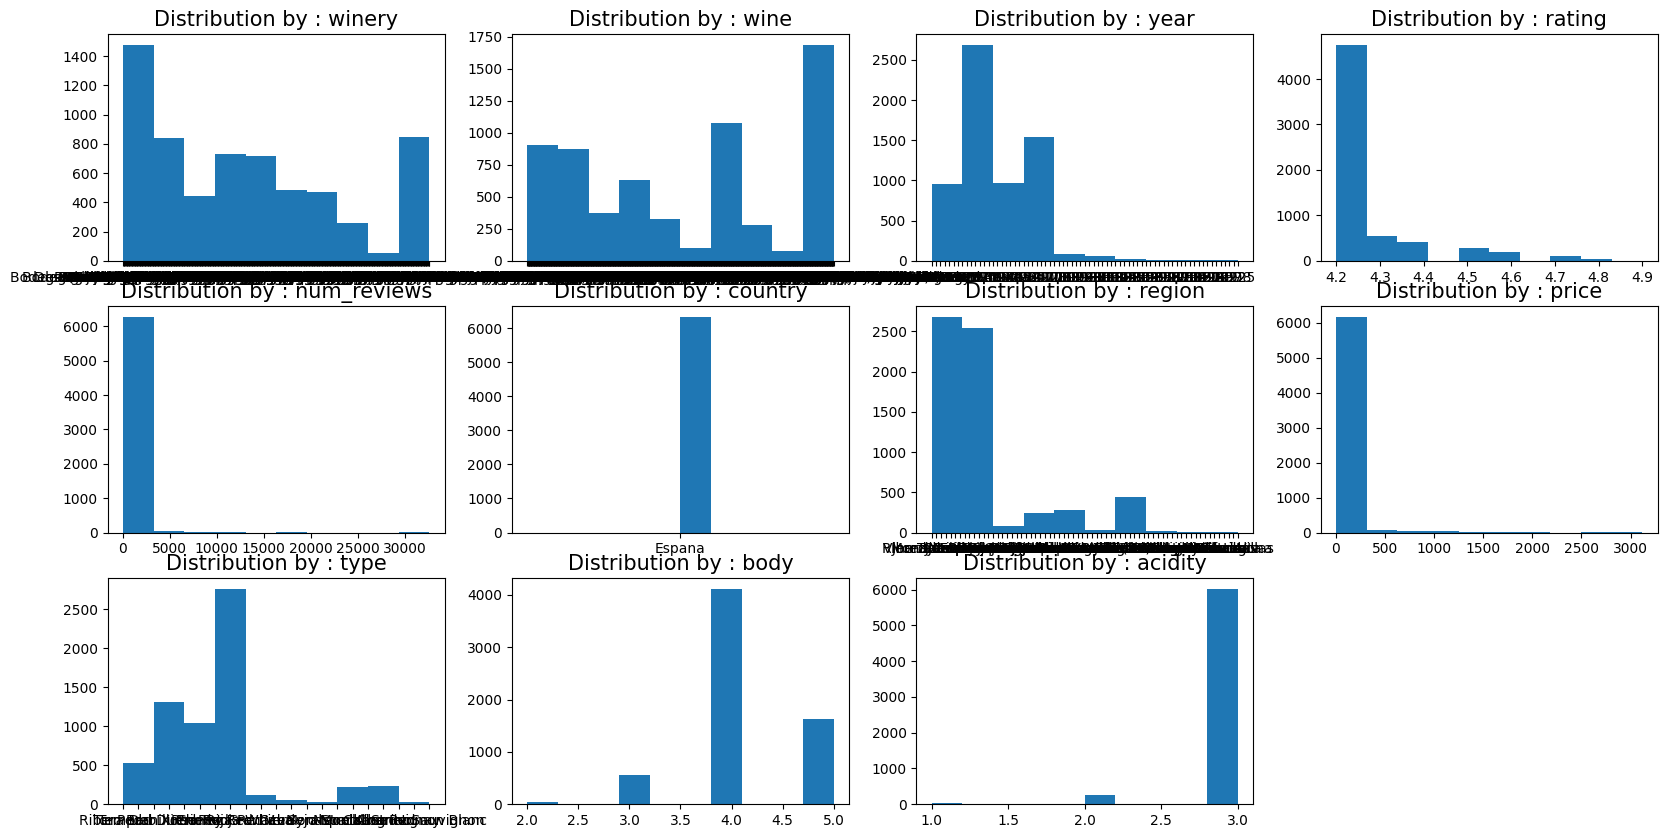

In [7]:
hist_distributions(df)
    

In [8]:
df.corr()

/var/folders/rw/3l7m_pl90hgbgv97f87910n00000gn/T/ipykernel_9635/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,rating,num_reviews,price,body,acidity
rating,1.000000,-0.009426,0.551707,0.162480,-0.094204
num_reviews,-0.009426,1.000000,-0.040498,0.064757,0.040229
price,0.551707,-0.040498,1.000000,0.153200,-0.033091
body,0.162480,0.064757,0.153200,1.000000,-0.018187
acidity,-0.094204,0.040229,-0.033091,-0.018187,1.000000


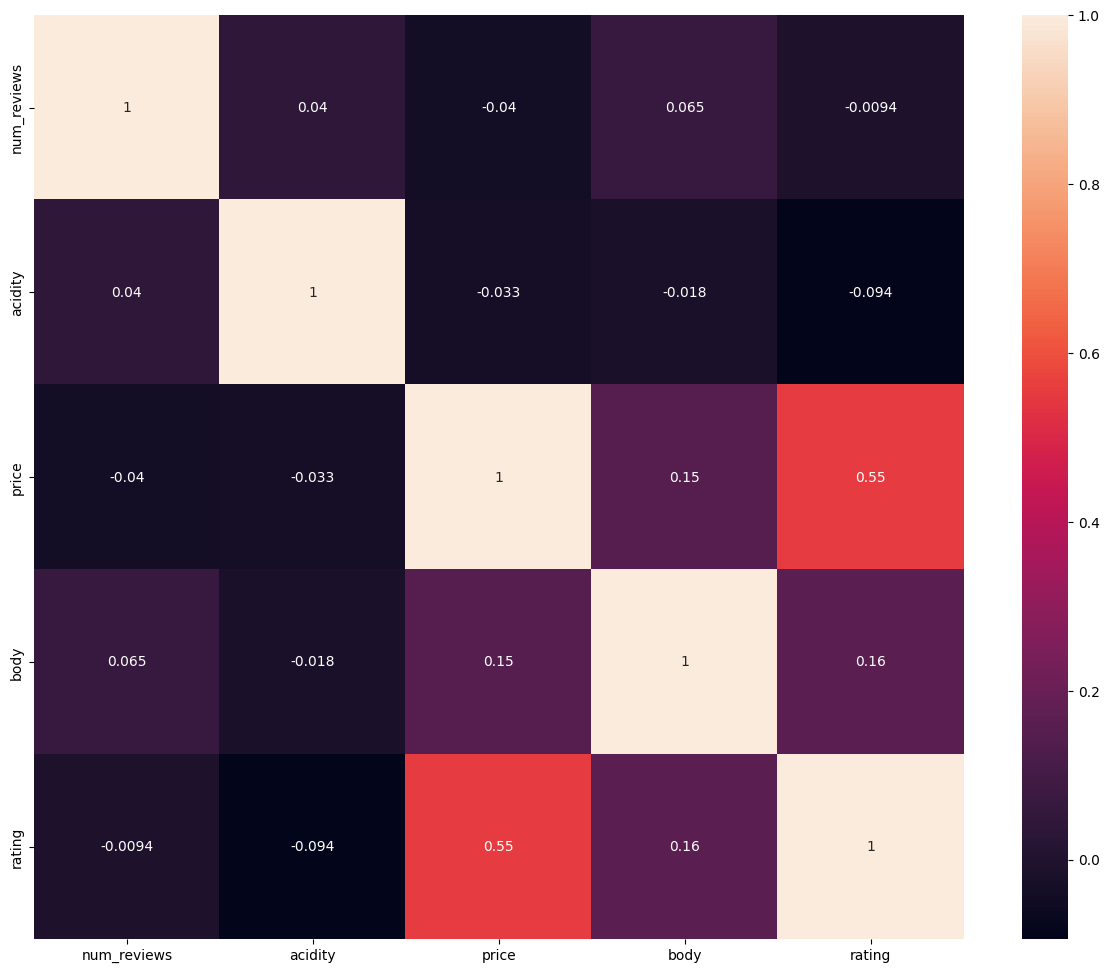

In [9]:
make_heatmap(df[['num_reviews','acidity','price','body','rating']])

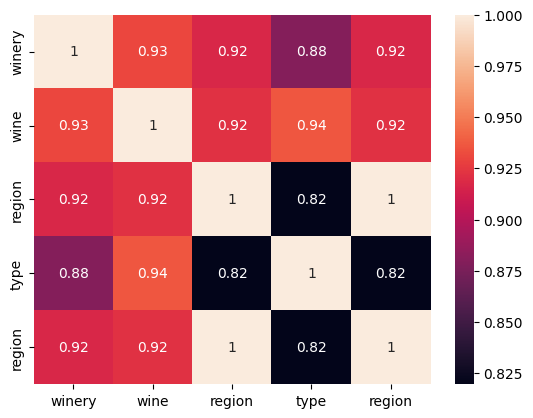

In [10]:
make_cat_heatmap(df,['winery','wine','region','type','region'])

# Vérifications du nombres de valeurs uniques


In [11]:
# Vérifications du nombres de valeurs uniques
view_unique_values(df, count=True)

column 0 : winery => 425 uniques values
column 1 : wine => 738 uniques values
column 2 : year => 71 uniques values
column 3 : rating => 8 uniques values
column 4 : num_reviews => 740 uniques values
column 5 : country => 1 uniques values
column 6 : region => 66 uniques values
column 7 : price => 1184 uniques values
column 8 : type => 21 uniques values
column 9 : body => 4 uniques values
column 10 : acidity => 3 uniques values


### Au vue des premières analyses, je décide de choisir en target (y) le 'rating' pour effectuer ma prédiction
### Au vue des distributions, je choisis comme première feature (X), la colonne "winery

# 1ère itérations : Linear Regression
### target = "rating"
### feature = "winery"

In [12]:
y = df[['rating']]
X = df[['winery']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=7)

first_pred = make_mix_pipeline()
first_pred.fit(X_train, y_train)
first_score = first_pred.score(X_test, y_test)
first_cv = cross_validate(first_pred, X_train, y_train, cv=5)['test_score'].mean()
print(f"score de prédiction sur le jeu de test :{first_score}")
print(f"score de cross-validation : {first_cv}")

score de prédiction sur le jeu de test :0.6276940932852497
score de cross-validation : 0.5862672943204706


### Résultat encoureageant, je fais tester d'ajouter des features pour la 2ème itérations 

# 2ème itérations : Linear Regression
### target = "rating"
### feature = "winery", "wine"

In [13]:
y_2 = df[['rating']]
X_2 = df[['winery','wine']]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2, test_size=0.3, random_state=7)

second_pred = make_mix_pipeline()
second_pred.fit(X_train_2, y_train_2)
second_score = second_pred.score(X_test_2, y_test_2)
second_cv = cross_validate(second_pred, X_train_2, y_train_2, cv=5)['test_score'].mean()
print(f"score de prédiction sur le jeu de test :{second_score}")
print(f"score de cross-validation : {second_cv}")

score de prédiction sur le jeu de test :0.7309519720414002
score de cross-validation : 0.7218101460326389


### Il y a une amélioration du modèle, le score cross-validation est proche du score de prédiction, notre modèle est donc plutôt généralisable.
### Je vais de cleaner les outliers sur mes features afin de voir si cela améliore le modèle.

In [14]:
# Je regarde la distributions des valeurs uniques sur ma features winery
# Je m'aperçois que sur 425 valeurs possibles, les 105 valeurs qui apparaissent le plus, 
# c'est à dire au minimun 4 fois, représente 91% de la distributions
# environ 25% des valeurs uniques de 'winery' => apparaissent 4 fois minimum => represente 91 % de la distribution.

print(view_values_frequency(df.winery).head(105).sum())
print(len(df.winery.value_counts()))


most_winery_appear = df.winery.value_counts().head(105).index.tolist()
df = df.loc[df['winery'].isin(most_winery_appear)]

91.19924158634855
425


In [15]:
# Je regarde la distributions des valeurs uniques sur ma features 'wine'
# Je m'aperçois que sur 335 valeurs possibles, les 105 valeurs qui apparaissent le plus
# c'est à dire au minimun 4 fois, représente 91% de la distributions
# environ 34% des valeurs uniques de 'wine' => apparaissent 4 fois minimum => represente 93 % de la distribution.
# Je sais egalement, qu'après avoir supprimé les valeurs nulles et ces 2 series d'outliers, il ne me restera que 0,72% des données de mon dataset de base

print(view_values_frequency(df.wine).head(116).sum())
print(len(df.wine.value_counts()))


most_wine_appear = df.wine.value_counts().head(116).index.tolist()
df = df.loc[df['wine'].isin(most_wine_appear)]
df
print(df.shape[0]/7500)

93.52044352044354
335
0.7197333333333333


# 3ème intérations : Linear Regression
### target = "rating"
### feature = "winery", "wine"

In [16]:

y_3 = df[['rating']]
X_3 = df[['winery','wine']]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,y_3, test_size=0.3, random_state=7)


third_pred = make_mix_pipeline()
third_pred.fit(X_train_3, y_train_3)
third_score = third_pred.score(X_test_3, y_test_3)
third_cv = cross_validate(third_pred, X_train_3, y_train_3, cv=5)['test_score'].mean()
print(f"score de prédiction sur le jeu de test : {third_score}")
print(f"score de cross-validation : {third_cv}")

score de prédiction sur le jeu de test : 0.8719880593753898
score de cross-validation : 0.8578766409073054


In [17]:
to_pred = pd.DataFrame(data={'winery':['Mustiguillo'],'wine':['Finca Terrerazo']})
print(f"prédiction : {round(float(third_pred.predict(to_pred)), 2)}")

prédiction : 4.2


### Après plusieurs tests supplémentaires (ajout de features), je n'obtiens pas de meilleur résultats.
### On pourrait eventuellement tester d'autre technique d'encodage, afin de voir si on peut obtenir un meilleur modèle

# 4ème intérations : Ridge Regression
### target = "rating"
### feature = "winery", "wine"

In [24]:
y_3 = df[['rating']]
X_3 = df[['winery','wine']]


X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,y_3, test_size=0.3, random_state=7)


third_pred = make_mix_pipeline(model=Ridge(alpha=0.4))
third_pred.fit(X_train_3, y_train_3)
third_score = third_pred.score(X_test_3, y_test_3)
third_cv = cross_validate(third_pred, X_train_3, y_train_3, cv=5)['test_score'].mean()
print(f"score de prédiction sur le jeu de test : {third_score}")
print(f"score de cross-validation : {third_cv}")

score de prédiction sur le jeu de test : 0.8728471835101348
score de cross-validation : 0.8559269783719138
